In [1]:
# 滤波代码
import pywt
from scipy import signal
# import matplotlib.pyplot as plt

def Wavelet_transform(ECG_Q):
    w = pywt.Wavelet('db8') # 选用Daubechies8小波
    maxlev = pywt.dwt_max_level(len(ECG_Q), w.dec_len)
    threshold = 0.1 # Threshold for filtering
    coeffs = pywt.wavedec(ECG_Q,'db8', level=maxlev) # 将信号进行小波分解
    #这里就是对每一层的coffe进行更改
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i])) 
    datarec = pywt.waverec(coeffs, 'db8') # 将信号进行小波重构
    return datarec

def butter_fliter(data, frequency, highpass, lowpass):
    [b, a] = signal.butter(3, [lowpass / frequency * 2, highpass / frequency * 2], 'bandpass')
    Signal_pro = signal.filtfilt(b, a, data)
    return Signal_pro


In [12]:
import scipy.io as scio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

ECG_01 = pd.read_csv("../Datasets/training_data.csv")["x"].to_numpy() # 训练集数据
ECG_01.shape

(102496,)

In [13]:
import time
import logging
import numpy as np
from biosppy.signals import ecg
import matplotlib.pyplot as plt

# 日志打印格式设定
logging.basicConfig(level = logging.DEBUG,format = '%(asctime)s - %(name)s - %(levelname)s - %(message)s',force=True)
logger = logging.getLogger(__name__)

# record = 'ECG_Raw_0401'

logging.info("--------------------------------------------------")
logging.info("载入ECG的信号, 长度 = %d " % len(ECG_01))
fs = 512  # 采样率为512 Hz
logging.info("调用 christov_segmenter 进行R波检测 ...")
tic = time.time()
rpeaks = ecg.christov_segmenter(ECG_01, sampling_rate=fs) # 调用christov_segmenter
toc = time.time()
logging.info("完成 christov_segmenter 用时: %f 秒. " % (toc - tic))
rpeaks_indices_1 = rpeaks[0]
logging.info("调用 hamilton_segmenter 进行R波检测 ...")
tic = time.time()
rpeaks = ecg.hamilton_segmenter(ECG_01, sampling_rate=fs) # 调用christov_segmenter
toc = time.time()
logging.info("完成 hamilton_segmenter 用时: %f 秒. " % (toc - tic))
rpeaks_indices_2 = rpeaks[0]

2023-05-04 20:04:47,239 - root - INFO - --------------------------------------------------
2023-05-04 20:04:47,239 - root - INFO - 载入ECG的信号, 长度 = 102496 
2023-05-04 20:04:47,241 - root - INFO - 调用 christov_segmenter 进行R波检测 ...
2023-05-04 20:04:48,741 - root - INFO - 完成 christov_segmenter 用时: 1.498485 秒. 
2023-05-04 20:04:48,741 - root - INFO - 调用 hamilton_segmenter 进行R波检测 ...
2023-05-04 20:04:48,834 - root - INFO - 完成 hamilton_segmenter 用时: 0.091897 秒. 


In [15]:
print(rpeaks_indices_1.shape)
# print(rpeaks_indices_2.shape)

(228,)
(234,)


2023-05-04 20:07:27,439 - root - INFO - 绘制波形图和检测的R波位置 ...


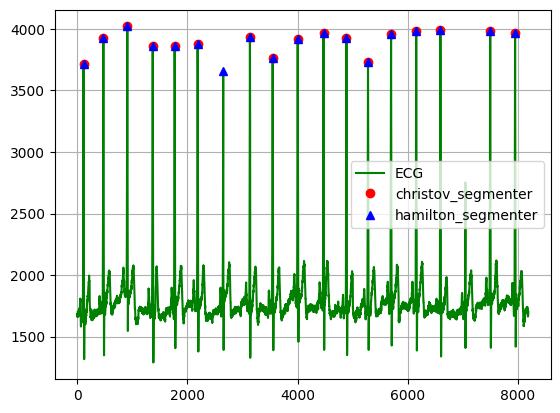

2023-05-04 20:07:27,577 - root - INFO - 完成.


In [18]:
# 绘波形图和R波位置
num_plot_samples = 1024*8
logging.info("绘制波形图和检测的R波位置 ...")
sig_plot = ECG_01[:num_plot_samples]
rpeaks_plot_1 = rpeaks_indices_1[rpeaks_indices_1 <= num_plot_samples]
plt.figure()
plt.plot(sig_plot, "g", label="ECG")
plt.grid(True)
plt.plot(rpeaks_plot_1, sig_plot[rpeaks_plot_1], "ro", label="christov_segmenter")
rpeaks_plot_3 = rpeaks_indices_2[rpeaks_indices_2 <= num_plot_samples]
plt.plot(rpeaks_plot_3, sig_plot[rpeaks_plot_3], "b^", label="hamilton_segmenter")
plt.legend()
plt.show()
logging.info("完成.")

In [31]:
length = len(ECG_01)
ECG_Signal = np.empty(shape=[0,370])
for site in rpeaks_indices_2:
    if 185< site < length-185:
        ECG_signal = ECG_01.flatten().tolist()[site-185:site+185]
        ECG_Signal = np.row_stack((ECG_Signal,ECG_signal))

### 前面已经处理成我们想要的ndarray的形状了

In [45]:
import scipy.io as scio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
# 标准化
def standscaler_demo(date):
    transfer = StandardScaler()
    date1 = transfer.fit_transform(date)
    return date1

# 数据读进来处理的封装函数，只需要进行滤波操作和标准化操作
def ECG_process(ECG):
    ECG_filtered = np.zeros(ECG.shape)
    for line in range(0,ECG.shape[0]):
        ECG_filtered[line] = Wavelet_transform(ECG[line])
    ECG_standed = standscaler_demo(ECG_filtered)
    return ECG_filtered,ECG_standed   # 返回值为两个数组

ECG_filtered,ECG_standed = ECG_process(ECG_Signal) 

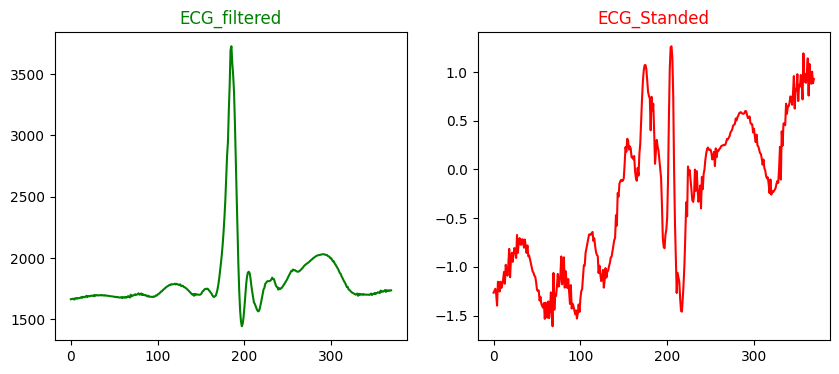

In [54]:
plt.figure(figsize = (10, 4))
plt.subplot(1,2,1)
plt.title("ECG_filtered",color="g")
plt.plot(ECG_filtered[0], color='g') 
plt.subplot(1,2,2)
plt.title("ECG_Standed",color="r")
plt.plot(ECG_standed[0], color='r')
plt.show()

### 得到结论：ECG_filtered被用来训练效果应该是最好的，而不是经过标准化的ECG_standed
#### 另外,我们也对数据进行了PCA降维处理,归一化等处理,结果都是不如数据直接经过滤波操作的效果好

In [57]:
ECG_filtered.shape

(233, 370)

该图绘制的是ECG_filtered的第191条数据


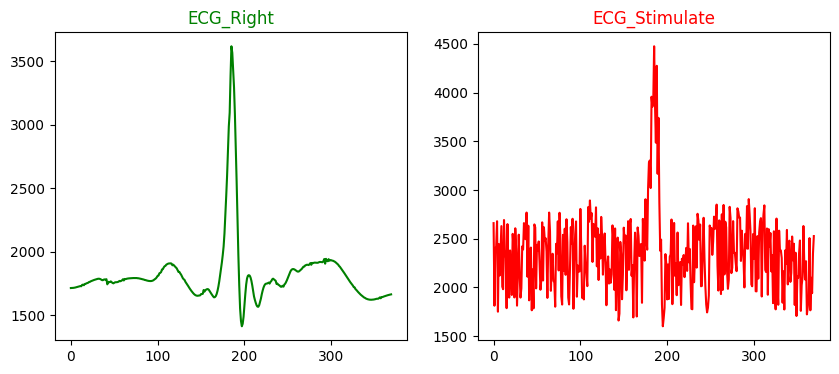

In [69]:
import random
# 模拟非正常心电
ECG_stimulate = np.random.randint(0,1000,ECG_filtered.shape)
ECG_stimulate =  ECG_stimulate + ECG_filtered # 之前是一团,现在是一个心电的形状
# eg.
random_num = random.randint(0,ECG_filtered.shape[0]) # 随机生成一个数、
print('该图绘制的是ECG_filtered的第{}条数据'.format(random_num))
plt.figure(figsize = (10, 4))
plt.subplot(1,2,1)
plt.title("ECG_Right",color="g")
plt.plot(ECG_filtered[random_num], color='g') 
plt.subplot(1,2,2)
plt.title("ECG_Stimulate",color="r")
plt.plot(ECG_stimulate[random_num], color='r')
plt.show()

In [72]:
#  构建数据集
true_list = [1] * ECG_filtered.shape[0]
print("正确标签值列表", true_list)
error_list = [0] * ECG_stimulate.shape[0]
print("错误标签值列表", error_list )
for i in error_list:
    true_list.append(i)
target_list = true_list
print("目标值向量是：\n",target_list)

#  合并两个训练集为ndarray类型的数据
np_train = np.vstack((ECG_filtered,ECG_stimulate))
print("\n训练集ndarry格式的数据为:\n", np_train)

正确标签值列表 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
错误标签值列表 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [75]:
#  进行数据分割
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(np_train, target_list, test_size=0.2)

print("\n分割后用来训练的特征值是:\n", x_train)
print("\n分割后用来测试的特征值是:\n", x_test)
print("\n分割后用来训练的目标值是:\n", y_train)
print("\n分割后用来测试的目标值是:\n", y_test)


分割后用来训练的特征值是:
 [[1676.66177205 1697.4510121  1702.72423082 ... 1638.27967836
  1646.14279805 1650.3177567 ]
 [1788.18509142 1785.64359583 1789.64216934 ... 1718.59218309
  1712.4762109  1717.36397725]
 [2678.07198812 2226.97993244 1773.53464194 ... 2619.30071368
  1807.28119221 2172.89025819]
 ...
 [1828.44173385 2448.3434456  1875.8584665  ... 2149.28443259
  2335.65367589 2075.16415568]
 [2307.59962846 1861.97189658 1913.30862825 ... 1771.94833298
  2337.98204819 2499.523167  ]
 [1784.47082947 1784.54592614 1784.77334779 ... 1750.88253753
  1751.44427252 1751.72712645]]

分割后用来测试的特征值是:
 [[1750.36959144 1750.43461698 1750.5915741  ... 1759.9124595
  1760.18746752 1760.1944602 ]
 [2395.86668316 1774.92056324 2478.76946501 ... 2485.35896439
  2317.87711047 1889.02618398]
 [2367.02523332 2647.69135984 2426.38405404 ... 2175.18827625
  2142.17099002 1717.65660002]
 ...
 [2640.12143221 2701.27218888 2313.28178225 ... 2460.28284656
  2648.48269904 2513.58297615]
 [2140.39863006 2367.9324624

### 选择机器学习中的SVC
原因:
1.选择机器学习的原因
    (1)训练集的数据量不大,相较于深度学习,这个二分类模型就是一个简单的弱学习器,总之,可以用深度学习提取特征并进行训练,但是是没有必要的
    (2)使用机器学习能够使代码的健壮性更强,虽然这个二分类模型是一个弱学习器,仅可以区分正常心电和加入了高斯噪声的心电,但是完全可以加上很多个弱学习器使整个大模型变成一个强学习器,可以做一个很多弱学习器融合的集成学习,使得模型更加健壮
2.选择SVC的原因:
    在使用这个模型之前(two_classification_v1),我们小组也尝试过有监督学习分类算法的其他常规模型:KNN,逻辑回归,决策树,随机森林,但是模型最终的准确率都不如向量机,虽然我们使用的sklearn库将算法封装在里面的,相当于一个黑盒子,但是我们仍需对常见的机器学习算法做一定了解,经过一番思考,我们小组做出如下推测:和KNN,逻辑回归这几类算法将预测值用一个平面或者曲面不同,向量机算法是通过建立一个超平面将目标值所分开,心电数据作为一种时间序列,在我们没有经过波形提取之前,它的峰值出现在哪一个维度本身就是不确定的,就导致了最后所截取的心拍完全交错开来了,所以想要将不同目标的心电用一个平面或者一个曲面分割开来,这几乎是不可能的,所以如果使用这几类模型,评估器只能乱猜了,导致最后的准确路在百分之五十上下波动
    但是在使用这个模型之后(two_classification_v2),我认为完全可以使用KNN,logistics regression,因为这一次我们是将心拍最中间的值提取为R峰峰值,这样用平面或者曲面分开是有可能的

In [76]:
# 向量机
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
import pickle

estimator = SVC(random_state=6)
Svc_train = estimator.fit(x_train, y_train)
svc_tra = estimator.score(x_test, y_test)

# 模型保存
with open ("II. Classification(SVC)2.pickle","wb") as f:
    pickle.dump(Svc_train,f) #将训练好的模型svc_tra存储在变量f中，且保存到本地

# 模型的加载和使用
with open("II. Classification(SVC)2.pickle","rb") as f:
    SVM_load = pickle.load(f)

y_pre_svc = estimator.predict(x_test)
roc_svc_score = roc_auc_score(y_test, y_pre_svc)
svc_tre = estimator.score(x_test, y_test)
print("向量机的预测值是：\n", y_pre_svc)
print("实际值是:\n", y_test)
print("准确率是：\n", svc_tre)
print("auc指标是:\n",roc_svc_score) 
# II. Classification2

向量机的预测值是：
 [1 0 0 1 0 0 0 0 1 1 0 1 0 0 1 0 0 1 1 0 0 0 0 1 1 0 1 1 0 0 1 0 1 0 0 0 1
 1 1 1 1 1 0 0 1 1 1 1 0 1 0 0 0 1 1 1 0 1 0 0 0 1 0 1 0 0 1 1 0 1 1 0 0 1
 0 0 1 1 1 0 1 1 1 0 1 0 1 1 1 0 1 0 0 0]
实际值是:
 [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0]
准确率是：
 1.0
auc指标是:
 1.0
